# Colorizing black and white dog pictures with CNN autoencoder

In this project, a CNN autoencoder will be created, which try to colorize black and white pictures, and it will be used on a dataset with dog pictures. 

The used dataset is the Stanford dataset from dogs. It can found in http://vision.stanford.edu/aditya86/ImageNetDogs/

## 1. Data exploration

The dataset created for classifying dogs, so it's splitted into train, validation and test folders. Every species has a sepearate folder, and the pictures are in a folder wich named after the species.
The target is to create a colored pictures from a black and white picture, and the pictures, in the dataset are colored ones, so the data is self-labeled in this case. The input will be the picture converted to gray scale, and the output will be the colored one, so the folder structure won't be used.

The first target is to find all of the images, and visualize some of them

In [6]:
import os
import re
path = "dogImages/"
img_2_species = {}
#recursively collect all the files in the folder
for root, dirs, files in os.walk(path):
    dirname = os.path.basename(root)
    try:
        species = re.findall("[a-zA-Z_]{2,}", dirname)[0] #collect the species name
    except IndexError: continue
    for file in files:
        path = os.path.join(root, file)
        img_2_species[path] = species

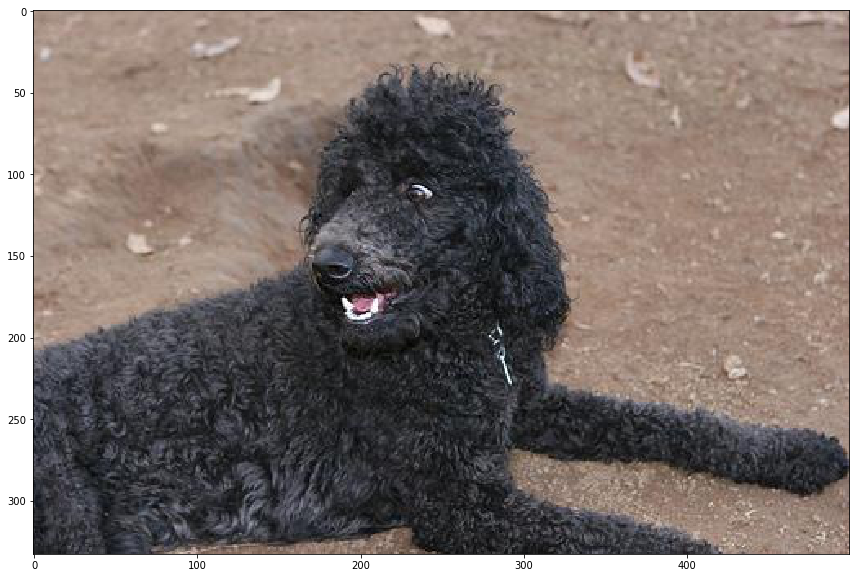

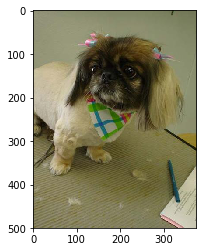

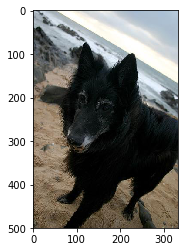

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#plot some random pictures from the dataset
n = 3
species = np.array(list(img_2_species.keys()))
choices = np.random.choice(species, n)
plt.figure(1, figsize=(20, 10))
for i, choice in enumerate(choices):
    img = mpimg.imread(choice)
    plt.imshow(img)
    plt.show()

In [8]:
import cv2

class Rescale: 
    def __init__(self, newSize):
        self.newSize = newSize
        return
    
    def __call__(self, img):
        h, w = img[:2]
        new_h, new_w = self.newSize
        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(img, (new_w, new_h))
        return img
        
        

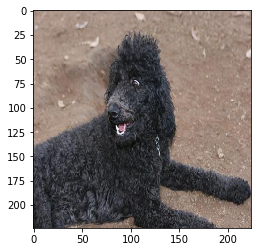

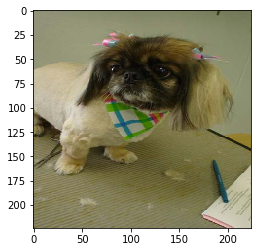

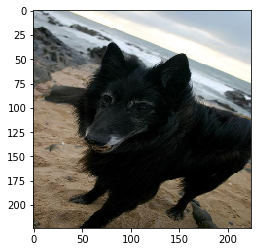

In [9]:
resc = Rescale((224, 224))
for i, choice in enumerate(choices):
    img = mpimg.imread(choice)
    img = resc(img)
    plt.imshow(img)
    plt.show()

## Dataloader

This part is based on the https://lukemelas.github.io/image-colorization.html blog post.

The main idea for colorization is that, we convert the pictures from RGB space to LAB space. In the LAB space, L stands for the ligthning, so the intensity of the black and white picture can be used as the L value, so the network shall learn only a and b value.

In Pytorch there are some comfort function for sampling and feed the network. To use them, a dataset class shall be created. In this case the DogDataset class is responsible to read the image, resize it, transform it to gray scale and LAB space. So it create the input and the ground truth for the network.

An additonal note: the complete dataset cannot fit to my memory, so this loading and transforming is moved to  getitem function.


In [13]:
import torch
from torch.utils.data import Dataset, random_split, RandomSampler, DataLoader

In [14]:
class DogDataset(Dataset):
    def __init__(self, imgs, transform=None):
        self.pics = imgs
        self.transform = transform
        return
    
    def __len__(self):
        return len(self.pics)
    
    def __getitem__(self, idx):
        img = mpimg.imread(self.pics[idx])
        if self.transform is not None:
            img = self.transform(img)
        grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grey = grey.astype(np.float32)
        grey = grey / 255
        input_ = torch.from_numpy(grey)
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        lab = lab.astype(np.float32)
        lab = lab / 255
        ab = lab[:, :, 1:3]
        output = torch.from_numpy(ab.transpose((2, 0, 1))).float()
        return input_, output

In [15]:
dataset = DogDataset(list(img_2_species.keys()),transform=resc)

Now the output is in LAB space, but for sanity check we should visualize our output, so a helper function is necessary for that purpose.

In [16]:
def visualize(input_, output, vis_grey=True):
    gray = (input_.numpy())
    output_ = np.zeros((224, 224, 3))
    output_[:, :, 0] = input_
    output_[:, :, 1:] = output.data.numpy().transpose(1, 2, 0)
    out = output_ * 255
    color = cv2.cvtColor(out.astype(np.uint8), cv2.COLOR_Lab2LBGR)
    if vis_grey:
        plt.imshow(gray, cmap="gray")
        plt.show()
    plt.imshow(color)
    plt.show()

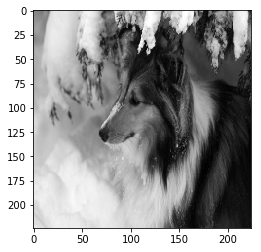

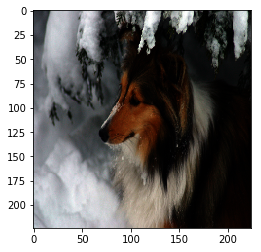

In [17]:
visualize(*dataset[60])

In [19]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

## The neural network

The network will have two part. One part for the convolution, on part is for the deconvolution. For the convolution part the first 6 layers of resnet18 will be used (as in the https://lukemelas.github.io/image-colorization.html blogpost). 

The convolution part is reponsible for feautre extraction, and the deconvolution is to reconstructure to the original size.

Note: the orinal resnet is designed for RGB pictures, so the an input with 3 color channel is expected, but in the gray scale, image has only 1 color channel, so the first layer shall be modify according this.

In [20]:
class ColorizationNet(nn.Module):
    def __init__(self, input_size=128):
        super(ColorizationNet, self).__init__()
        MIDLEVEL_FEATURE_SIZE = 128

        ## First half: ResNet
        resnet = models.resnet18() 
        # Change first conv layer to accept single-channel (grayscale) input
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
        # Extract midlevel features from ResNet-gray
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

        ## Second half: Upsampling
        self.upsample = nn.Sequential(     
          nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
          nn.Upsample(scale_factor=2)
        )
        
    def forward(self, input):
        # Pass input through ResNet-gray to extract features
        midlevel_features = self.midlevel_resnet(input)

        # Upsample to get colors
        output = self.upsample(midlevel_features)
        return output


In [21]:
net = ColorizationNet()

After the network is created, the dataset shall be splitted for test and train dataset. The ratio for the test dataset is very very low, because in this case, accuracy cannot computed easily and the loss is has very limited meaning for human. So to check the correctness of the network can be done with manually. The dataset contains ~20 000 pictures, so if the test dataset is only the 5%, we will have ~1000 pictures to check manually.

In [22]:
TEST_RATIO = 0.05
LEN_TEST_DATASET = int(TEST_RATIO * len(dataset))

In [24]:
testDataset, trainDataset = random_split(dataset, [LEN_TEST_DATASET, len(dataset) - LEN_TEST_DATASET])
loader = DataLoader(trainDataset, batch_size=32)

The output of network should be checked before any training, if the weight are initialized truly randomly

/home/kovesdv/anaconda3/envs/py/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


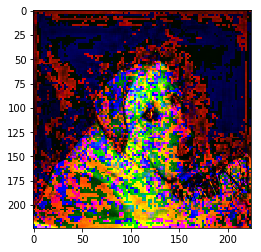

In [25]:
im_grey, im_ab = testDataset[0]
input_ = im_grey.unsqueeze(0).unsqueeze(0)
visualize(im_grey, net(input_)[0], vis_grey=False)

For training the MSE loss is used, and the ADAM optimizer with default parameters. The training is run on https://colab.research.google.com/ And the weights of the network are saved. The train function can be seen below. Some screenshot from the training is also attached below the training code.

In [26]:
import torch.optim as optim
number_of_epochs = 0#101
display_in_every = 20
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

In [28]:
test_image_gray = None
for epoch in range(number_of_epochs):
    for i, (im_gray, im_ab) in enumerate(loader):
        if epoch == 0 and i == 0:
            test_image_gray = im_gray
            test_img_input = test_image_gray.unsqueeze(1).float()
            test_img_input = test_img_input.to("cuda:0")
            
            print("----------------Original image----------------------")
            visualize(test_image_gray[0], im_ab[0], vis_grey=False)
            print("----------------------------------------------------")
        optimizer.zero_grad()
        input_ = im_gray.unsqueeze(1).float()
        #print(im_gray.unsqueeze(1).size(), input_.size())
        input_ = input_.to("cuda:0")
        im_ab = im_ab.to("cuda:0")
        #print(im_ab.size())
        #im_ab = torch.from_numpy(im_ab.numpy().transpose((2, 0, 1))).float()
        output = net(input_)
        loss = criterion(output, im_ab)
        loss.backward()
        optimizer.step()
    if epoch % display_in_every == 0:
        print("Train epoch: {} Loss: {:.4f}".format(epoch, loss.data[0]))
        visualize(test_image_gray[0], net(test_img_input)[0].to("cpu"), vis_grey=False)
torch.save(net.state_dict(), "models/dogModel1_xxx.pth")

![Original Image](img/dog_training_original1.png)
![Original Image](img/dog_training_last.png)

The weights are loaded wich saved during the training in colab, and tested for a subset of the test dataset. Only 50 pieces of testdataset is chosen for sanity check

/home/kovesdv/anaconda3/envs/py/lib/python3.6/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU0 GeForce 610M which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))
/home/kovesdv/anaconda3/envs/py/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


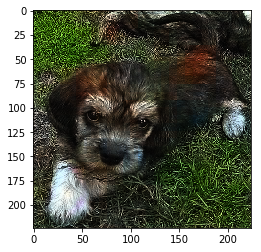

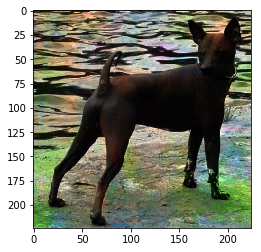

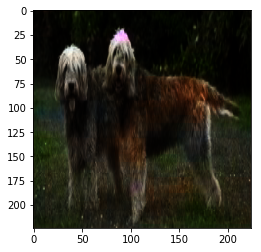

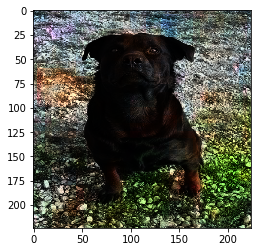

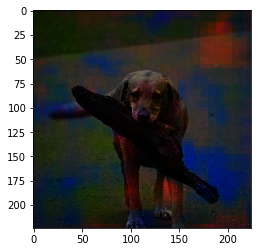

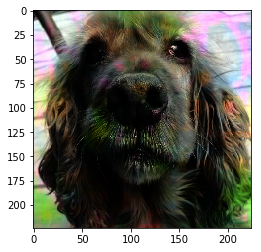

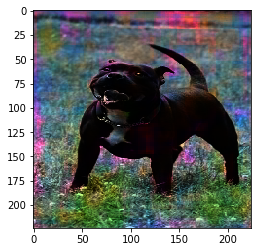

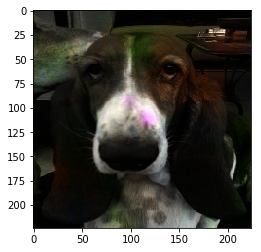

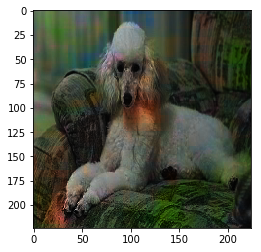

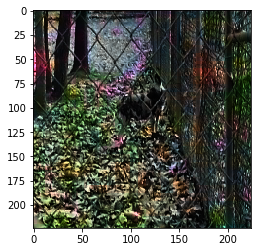

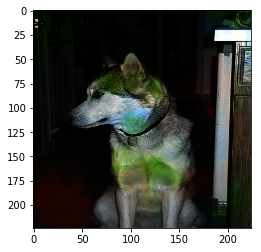

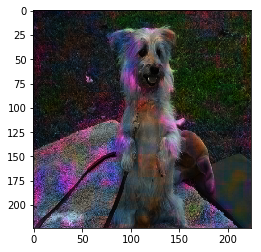

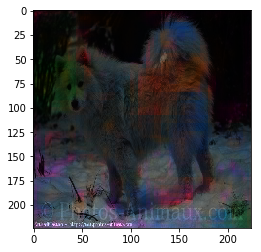

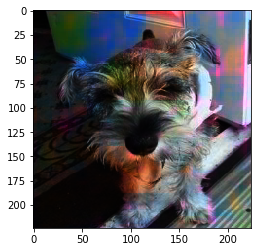

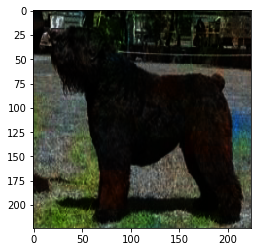

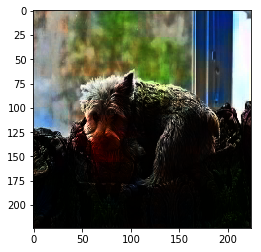

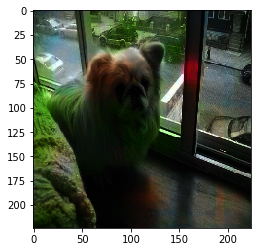

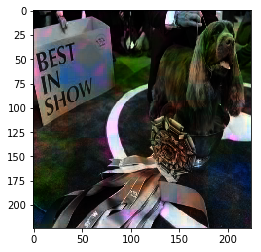

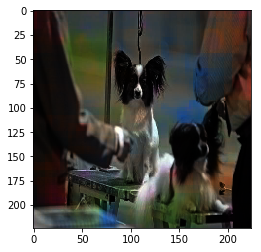

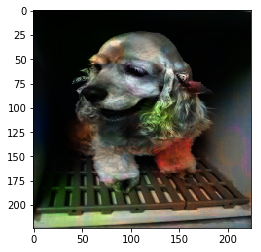

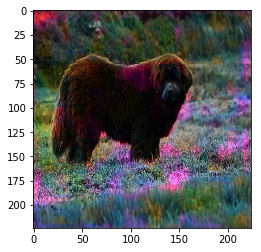

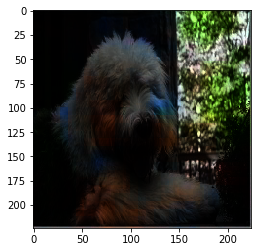

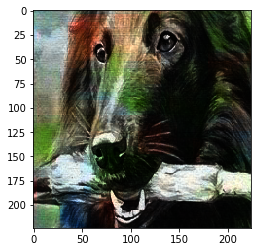

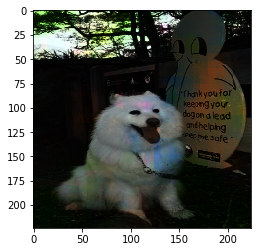

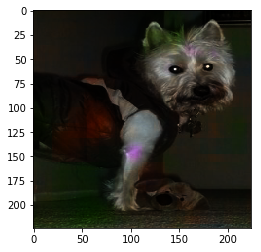

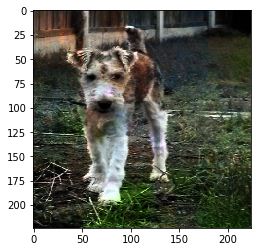

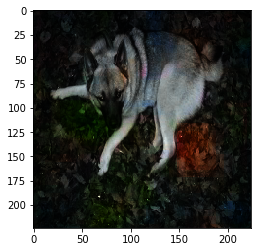

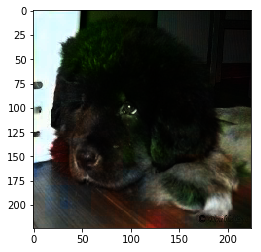

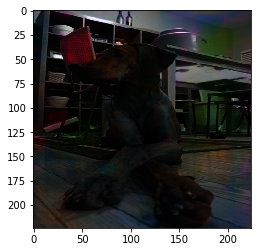

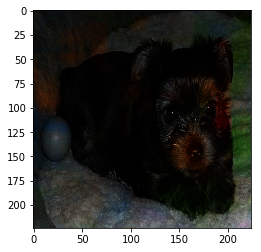

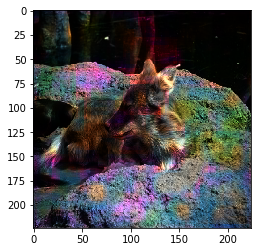

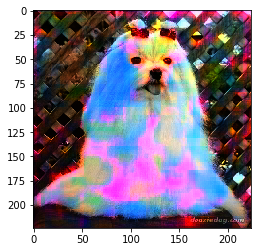

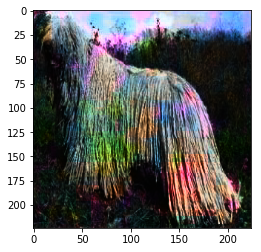

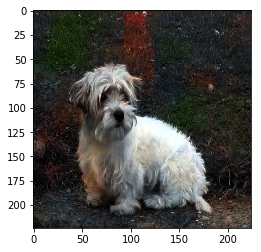

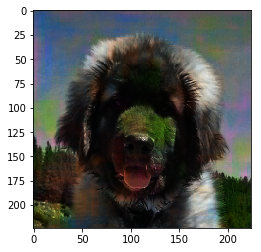

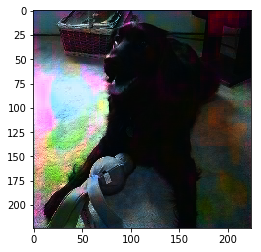

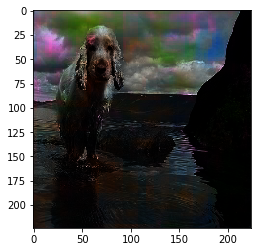

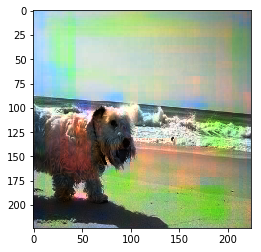

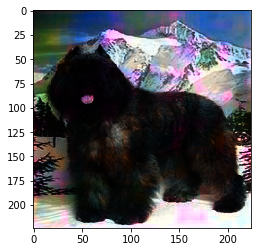

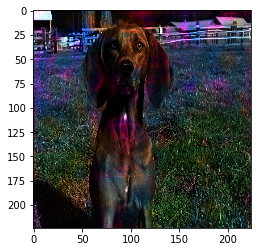

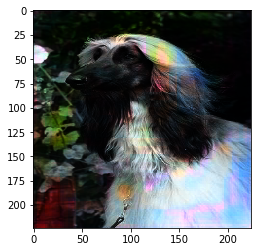

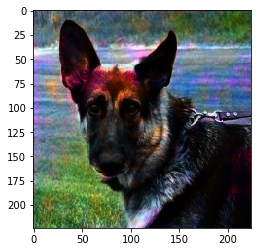

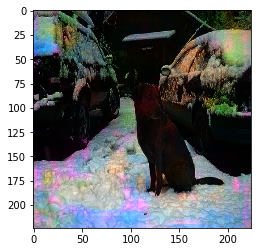

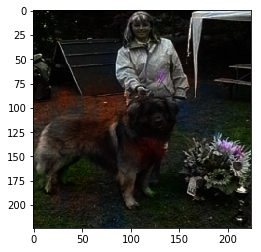

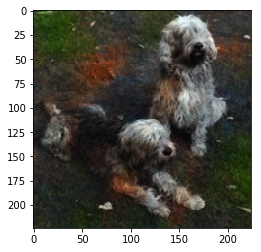

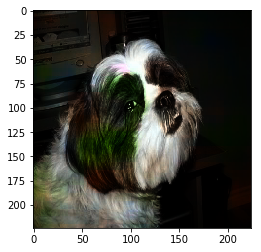

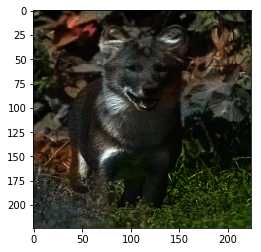

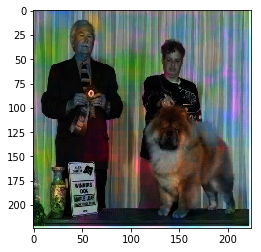

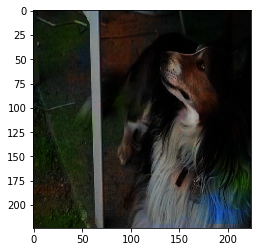

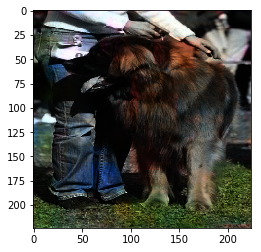

In [33]:
net.load_state_dict(torch.load("models/dogModel1_3.pth"))
smallTestDataset, bigTestDataset = random_split(testDataset, [50, len(testDataset) - 50])
loader = DataLoader(smallTestDataset)
with torch.no_grad():
    for im_gray, im_ab in loader:
        input_ = im_gray.unsqueeze(0).float()
        #print(im_ab.size())
        #im_ab = torch.from_numpy(im_ab.numpy().transpose((2, 0, 1))).float()
        visualize(im_gray[0], net(input_)[0], vis_grey=False)